In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

In [174]:
df = pd.read_csv('./data/player_game_data.csv')

In [227]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [176]:
df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'])
df = df.set_index('GAME_DATE_EST')
df.dropna(inplace= True)
df.sort_index(inplace= True)

In [177]:
df= df[['PLAYER_NAME', 'PLAYER_ID','GAME_ID', 'SEASON','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TNO','PF','PTS','PLUS_MINUS','SECONDS','FTSY_PTS']]
df.head()

,PLAYER_NAME,PLAYER_ID,GAME_ID,SEASON,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TNO,PF,PTS,PLUS_MINUS,SECONDS,FTSY_PTS
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,,,,,,
2015-10-02,C.J. Wilcox,203912,11500001,2015,1.0,2.0,0.500,1.0,2.0,0.500,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,446,2.0
2015-10-02,Jameer Nelson,2749,11500001,2015,3.0,8.0,0.375,1.0,3.0,0.333,3.0,4.0,0.75,0.0,3.0,3.0,7.0,0.0,0.0,1.0,3.0,10.0,8.0,1141,16.5
2015-10-02,Randy Foye,200751,11500001,2015,2.0,4.0,0.500,2.0,2.0,1.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,6.0,-16.0,1138,3.0
2015-10-02,Wilson Chandler,201163,11500001,2015,5.0,12.0,0.417,1.0,3.0,0.333,0.0,1.0,0.00,1.0,7.0,8.0,2.0,2.0,0.0,0.0,1.0,11.0,-8.0,1382,18.0
2015-10-02,JJ Hickson,201581,11500001,2015,1.0,7.0,0.143,0.0,0.0,0.000,0.0,0.0,0.00,1.0,5.0,6.0,0.0,0.0,0.0,3.0,2.0,2.0,-14.0,1148,-1.0


In [178]:
#issue with time series generator on y_test? It is a single value which is causing an error, Cannot wrap y_test in a list raises error
#start_index+length=1 > end_index=0` is disallowed, as no part of the sequence would be left to be used as current step.
# above error prevents manually setting stop and start index with y_test len of 1
# 
def player_output():
#     day = input('What day would you like to predict? Format: YYYY-MM-DD')
#     player = input('What player would you like to predict?')
    
    day= '2016-11-25'
    player= 'Stephen Curry'
    
    data_df = df.loc[df['PLAYER_NAME'] == player]
    data_df = data_df.iloc[:,4:-1].rolling(window=5).mean()
    data_df['FTSY_PTS'] = df.loc[df['PLAYER_NAME']== player]['FTSY_PTS']
    data_df.dropna(inplace= True)
    
    
    X_train = data_df.loc['2015-10-02': day].drop(columns= 'FTSY_PTS')
    
    y_train = data_df.loc['2015-10-02': day]['FTSY_PTS']
    
    
    X_test = data_df.loc[day].drop('FTSY_PTS')
    y_test = [data_df.loc[day]['FTSY_PTS']]

    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test.values.reshape(1,-1))
    
#     train_seq = TimeseriesGenerator(X_train_sc, y_train, length=1, batch_size=64)
#     test_seq = TimeseriesGenerator(X_test_sc, y_test, length = 1, batch_size=64)
    
#     model = Sequential()

#     model.add(LSTM(64, input_shape=(1,20), return_sequences=True))
#     model.add(LSTM(16, return_sequences=False))

#     model.add(Dense(16, activation= 'relu'))
#     model.add(Dropout(.1))

#     model.add(Dense(8, activation= 'relu'))
#     model.add(Dropout(.1))

#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss= 'mse', metrics= ['mae'])

#     early_stop = EarlyStopping(patience = 5)

#     history=model.fit(train_seq, epochs=100, validation_data= test_seq, verbose=1, callbacks = [early_stop])

In [244]:
def player_output():
    day = input('What day would you like to predict? Format: YYYY-MM-DD')
    player = input('What player would you like to predict?')
    
    data_df = df.loc[df['PLAYER_NAME'] == player]
    data_df = data_df.iloc[:,4:-1].rolling(window=5).mean()
    data_df['FTSY_PTS'] = df.loc[df['PLAYER_NAME']== player]['FTSY_PTS']
    data_df.dropna(inplace= True)
    
    
    X_train = data_df.loc['2015-10-02': day].drop(columns= 'FTSY_PTS')
    y_train = data_df.loc['2015-10-02': day]['FTSY_PTS']
    
    #https://stackoverflow.com/questions/46533410/pandas-datetimeindex-shifting-over-index
    day_ind = data_df.index.get_loc(day)
    X_test = data_df.iloc[[day_ind,day_ind+1]].drop(columns = 'FTSY_PTS')
    y_test = data_df.iloc[[day_ind,day_ind+1]]['FTSY_PTS']

    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    
    train_seq = TimeseriesGenerator(X_train_sc, y_train, length=1, batch_size=64)
    #test_seq = TimeseriesGenerator(X_test_sc, y_test, length = 1, batch_size=64)
    
    model = Sequential()

    model.add(LSTM(64, input_shape=(1,20), return_sequences=True))
    model.add(LSTM(32, return_sequences=False))

    model.add(Dense(32, activation= 'relu'))
    model.add(Dropout(.1))

    model.add(Dense(8, activation= 'relu'))
    model.add(Dropout(.1))

    model.add(Dense(2))
    model.compile(optimizer='adam', loss= 'mse', metrics= ['mae'])

    early_stop = EarlyStopping(patience = 5, restore_best_weights=True)

    history=model.fit(train_seq, epochs=100, validation_data= test_seq,
                      verbose=1, callbacks = [early_stop])
    output = model.predict(test_seq)
    return output

In [245]:
player_output()

What day would you like to predict? Format: YYYY-MM-DD 2016-11-25
What player would you like to predict? Stephen Curry


Epoch 1/100
2/2 [==============================] - 3s 645ms/step - loss: 1251.2069 - mae: 33.5591 - val_loss: 1680.4666 - val_mae: 40.9935
Epoch 2/100
2/2 [==============================] - 0s 46ms/step - loss: 1250.5638 - mae: 33.5492 - val_loss: 1680.0211 - val_mae: 40.9881
Epoch 3/100
2/2 [==============================] - 0s 43ms/step - loss: 1249.8774 - mae: 33.5394 - val_loss: 1679.5725 - val_mae: 40.9826
Epoch 4/100
2/2 [==============================] - 0s 43ms/step - loss: 1249.2634 - mae: 33.5306 - val_loss: 1679.1080 - val_mae: 40.9769
Epoch 5/100
2/2 [==============================] - 0s 43ms/step - loss: 1248.6212 - mae: 33.5208 - val_loss: 1678.6296 - val_mae: 40.9711
Epoch 6/100
2/2 [==============================] - 0s 43ms/step - loss: 1247.8979 - mae: 33.5105 - val_loss: 1678.1257 - val_mae: 40.9649
Epoch 7/100
2/2 [==============================] - 0s 44ms/step - loss: 1247.3134 - mae: 33.5010 - val_loss: 1677.5525 - val_mae: 40.9579
Epoch 8/100
2/2 [================

array([[35.43041 , 28.679668]], dtype=float32)

In [326]:
day= '2016-11-25'
player= 'Stephen Curry'


data_df = df.loc[df['PLAYER_NAME'] == player]
data_df = data_df.iloc[:,4:-1].rolling(window=5).mean()
data_df['FTSY_PTS'] = df.loc[df['PLAYER_NAME']== player]['FTSY_PTS']
data_df.dropna(inplace= True)


X_train = data_df.loc['2015-10-02': day].drop(columns= 'FTSY_PTS')
X_train = X_train[:-1]
y_train = data_df.loc['2015-10-02': day]['FTSY_PTS']
y_train = y_train[:-1]

#https://stackoverflow.com/questions/46533410/pandas-datetimeindex-shifting-over-index
day_ind = data_df.index.get_loc(day)
X_test = data_df.iloc[[day_ind,day_ind+1]].drop(columns = 'FTSY_PTS')
y_test = data_df.iloc[[day_ind,day_ind+1]]['FTSY_PTS']

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

train_seq = TimeseriesGenerator(X_train_sc, y_train, length=1, batch_size=64)
test_seq = TimeseriesGenerator(X_test_sc, y_test, length = 1, batch_size=64)

model = Sequential()

model.add(LSTM(64, input_shape=(1,20), return_sequences=True))
model.add(LSTM(32, return_sequences=False))

model.add(Dense(32, activation= 'relu'))
model.add(Dropout(.1))

model.add(Dense(8, activation= 'relu'))
model.add(Dropout(.1))

model.add(Dense(2))
model.compile(optimizer='adam', loss= 'mse', metrics= ['mae'])

early_stop = EarlyStopping(patience = 5)

results=model.fit(train_seq, epochs=100, validation_data=test_seq,
                  verbose=1, callbacks = [early_stop])

output= model.predict(test_seq)

player_df = pd.DataFrame(columns = ['player', 'Game_1', 'Game_2'])
row = pd.Series([player, output[0][0], output[0][1]], index=['player', 'Game_1', 'Game_2'])
player_df = player_df.append(row, ignore_index= True)
print(player_df)

Epoch 1/100
2/2 [==============================] - 4s 669ms/step - loss: 1254.3416 - mae: 33.5913 - val_loss: 1680.8000 - val_mae: 40.9976
Epoch 2/100
2/2 [==============================] - 0s 43ms/step - loss: 1253.7880 - mae: 33.5826 - val_loss: 1680.3232 - val_mae: 40.9917
Epoch 3/100
2/2 [==============================] - 0s 43ms/step - loss: 1253.2491 - mae: 33.5746 - val_loss: 1679.8733 - val_mae: 40.9863
Epoch 4/100
2/2 [==============================] - 0s 43ms/step - loss: 1252.8134 - mae: 33.5685 - val_loss: 1679.3655 - val_mae: 40.9801
Epoch 5/100
2/2 [==============================] - 0s 41ms/step - loss: 1252.4003 - mae: 33.5620 - val_loss: 1678.8080 - val_mae: 40.9733
Epoch 6/100
2/2 [==============================] - 0s 42ms/step - loss: 1251.9908 - mae: 33.5559 - val_loss: 1678.2061 - val_mae: 40.9659
Epoch 7/100
2/2 [==============================] - 0s 41ms/step - loss: 1251.6517 - mae: 33.5508 - val_loss: 1677.5718 - val_mae: 40.9582
Epoch 8/100
2/2 [================

In [327]:
player_df


,player,Game_1,Game_2
0,Stephen Curry,36.090134,34.524742


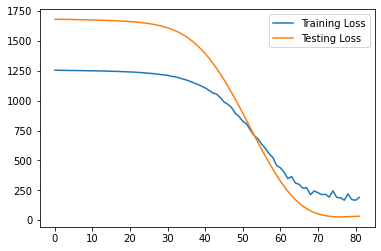

In [328]:
plt.plot(results.history['loss'], label = 'Training Loss')
plt.plot(results.history['val_loss'], label = 'Testing Loss')
plt.legend();


In [319]:
player_lst = ['Stephen Curry', 'LeBron James', 'Kevin Durant']
date_range = pd.date_range(start= '2018-01-11', end = '2018-01-18')
player_df = pd.DataFrame()
   
for player in player_lst:
    data_df = df.loc[df['PLAYER_NAME'] == player]
    data_df = data_df.iloc[:,4:-1].rolling(window=5).mean()
    data_df['FTSY_PTS'] = df.loc[df['PLAYER_NAME']== player]['FTSY_PTS']
    data_df.dropna(inplace= True)
    
    output_lst = []
    for day in date_range:
        if day in data_df.index:
            X_train = data_df.loc['2015-10-02': day].drop(columns= 'FTSY_PTS')
            X_train = X_train[:-1]
            y_train = data_df.loc['2015-10-02': day]['FTSY_PTS']
            y_train = y_train[:-1]
            
            day_ind = data_df.index.get_loc(day)
            X_test = data_df.iloc[[day_ind,day_ind+1]].drop(columns = 'FTSY_PTS')
            y_test = data_df.iloc[[day_ind,day_ind+1]]['FTSY_PTS']
            
            ss = StandardScaler()
            X_train_sc = ss.fit_transform(X_train)
            X_test_sc = ss.transform(X_test)

            train_seq = TimeseriesGenerator(X_train_sc, y_train, length=1, batch_size=64)
            test_seq = TimeseriesGenerator(X_test_sc, y_test, length = 1, batch_size=64)

            model = Sequential()

            model.add(LSTM(64, input_shape=(1,20), return_sequences=True))
            model.add(LSTM(32, return_sequences=False))

            model.add(Dense(32, activation= 'relu'))
            model.add(Dropout(.1))

            model.add(Dense(8, activation= 'relu'))
            model.add(Dropout(.1))

            model.add(Dense(2))
            model.compile(optimizer='adam', loss= 'mse', metrics= ['mae'])

            early_stop = EarlyStopping(patience = 5, restore_best_weights=True)

            history=model.fit(train_seq, epochs=100, validation_data=test_seq,
                              verbose=1, callbacks = [early_stop])
            
            output = model.predict(train_seq)
            output_lst.append(output[0][0])
    row = pd.Series(output_lst)
    player_df = player_df.append(row, ignore_index= True)
player_df.index = player_lst 

player_df

Epoch 1/100
4/4 [==============================] - 4s 300ms/step - loss: 1186.4424 - mae: 32.7880 - val_loss: 1023.7269 - val_mae: 31.9957
Epoch 2/100
4/4 [==============================] - 0s 21ms/step - loss: 1185.6611 - mae: 32.7760 - val_loss: 1023.0283 - val_mae: 31.9848
Epoch 3/100
4/4 [==============================] - 0s 21ms/step - loss: 1185.0491 - mae: 32.7667 - val_loss: 1022.4020 - val_mae: 31.9750
Epoch 4/100
4/4 [==============================] - 0s 21ms/step - loss: 1184.4236 - mae: 32.7572 - val_loss: 1021.7523 - val_mae: 31.9649
Epoch 5/100
4/4 [==============================] - 0s 22ms/step - loss: 1183.6600 - mae: 32.7453 - val_loss: 1020.9706 - val_mae: 31.9526
Epoch 6/100
4/4 [==============================] - 0s 21ms/step - loss: 1182.8823 - mae: 32.7331 - val_loss: 1020.0448 - val_mae: 31.9381
Epoch 7/100
4/4 [==============================] - 0s 22ms/step - loss: 1181.9771 - mae: 32.7199 - val_loss: 1019.0226 - val_mae: 31.9221
Epoch 8/100
4/4 [================

TypeError: Index(...) must be called with a collection of some kind, 'Players' was passed

In [305]:
player_df


,0,1,2,3
Stephen Curry,39.417320,36.577568,27.352371,NaN
LeBron James,39.202797,45.097622,28.882462,15.616510
Kevin Durant,33.033493,43.634056,39.577541,38.916779


,PLAYER_NAME,PLAYER_ID,GAME_ID,SEASON,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TNO,PF,PTS,PLUS_MINUS,SECONDS,FTSY_PTS
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,,,,,,
2018-12-17,Stephen Curry,201939,21800449,2018,6.0,16.0,0.375,3.0,9.0,0.333,5.0,5.0,1.000,0.0,7.0,7.0,1.0,2.0,0.0,3.0,3.0,20.0,19.0,2102,19.5
2018-12-19,Stephen Curry,201939,21800464,2018,12.0,21.0,0.571,5.0,9.0,0.556,3.0,3.0,1.000,1.0,2.0,3.0,3.0,3.0,1.0,4.0,4.0,32.0,-6.0,2220,34.5
2018-12-22,Stephen Curry,201939,21800484,2018,7.0,22.0,0.318,6.0,17.0,0.353,2.0,3.0,0.667,2.0,3.0,5.0,5.0,2.0,0.0,3.0,5.0,22.0,-3.0,2369,19.5


In [308]:
def full_model():
    
    start= input("What is the first day of the week?")
    end= input("What is the last day of the week?")
    date_range= pd.date_range(start= start, end = end)
    
    player_lst = []
    roster_size = int(input("How many players are on your roster?"))
    for i in range(roster_size):
        player_lst.append(input("Type a player's name here."))
    player_df= pd.DataFrame() 
    
    for player in player_lst:
        data_df = df.loc[df['PLAYER_NAME'] == player]
        data_df = data_df.iloc[:,4:-1].rolling(window=5).mean()
        data_df['FTSY_PTS'] = df.loc[df['PLAYER_NAME']== player]['FTSY_PTS']
        data_df.dropna(inplace= True)
    
        output_lst = []
        
        for day in date_range:
            if day in data_df.index:
                X_train = data_df.loc['2015-10-02': day].drop(columns= 'FTSY_PTS')
                X_train = X_train[:-1]
                y_train = data_df.loc['2015-10-02': day]['FTSY_PTS']
                y_train = y_train[:-1]

                day_ind = data_df.index.get_loc(day)
                X_test = data_df.iloc[[day_ind,day_ind+1]].drop(columns = 'FTSY_PTS')
                y_test = data_df.iloc[[day_ind,day_ind+1]]['FTSY_PTS']

                ss = StandardScaler()
                X_train_sc = ss.fit_transform(X_train)
                X_test_sc = ss.transform(X_test)

                train_seq = TimeseriesGenerator(X_train_sc, y_train, length=1, batch_size=64)
                test_seq = TimeseriesGenerator(X_test_sc, y_test, length = 1, batch_size=64)

                model = Sequential()

                model.add(LSTM(64, input_shape=(1,20), return_sequences=True))
                model.add(LSTM(32, return_sequences=False))

                model.add(Dense(32, activation= 'relu'))
                model.add(Dropout(.1))

                model.add(Dense(8, activation= 'relu'))
                model.add(Dropout(.1))

                model.add(Dense(2))
                model.compile(optimizer='adam', loss= 'mse', metrics= ['mae'])

                early_stop = EarlyStopping(patience = 5, restore_best_weights=True)

                history=model.fit(train_seq, epochs=100, validation_data=test_seq,
                                  verbose=1, callbacks = [early_stop])

                output = model.predict(train_seq)
                output_lst.append(output[0][0])
        row = pd.Series(output_lst)
        player_df = player_df.append(row, ignore_index= True)
    player_df.index = player_lst 
    return player_df

In [309]:
full_model()


What is the first day of the week? 2019-01-08
What is the last day of the week? 2019-01-15
How many players are on your roster? 6
Type a player's name here. Stephen Curry
Type a player's name here. LeBron James
Type a player's name here. Kevin Durant
Type a player's name here. Paul George
Type a player's name here. Damian Lillard
Type a player's name here. Kyrie Irving


Epoch 1/100
5/5 [==============================] - 5s 508ms/step - loss: 1155.3430 - mae: 32.2387 - val_loss: 1220.9034 - val_mae: 34.9414
Epoch 2/100
5/5 [==============================] - 0s 14ms/step - loss: 1152.8029 - mae: 32.1997 - val_loss: 1217.9775 - val_mae: 34.8995
Epoch 3/100
5/5 [==============================] - 0s 14ms/step - loss: 1149.8380 - mae: 32.1545 - val_loss: 1214.5520 - val_mae: 34.8504
Epoch 4/100
5/5 [==============================] - 0s 14ms/step - loss: 1146.5114 - mae: 32.1009 - val_loss: 1210.4668 - val_mae: 34.7918
Epoch 5/100
5/5 [==============================] - 0s 14ms/step - loss: 1142.7584 - mae: 32.0422 - val_loss: 1205.6863 - val_mae: 34.7230
Epoch 6/100
5/5 [==============================] - 0s 13ms/step - loss: 1137.9258 - mae: 31.9685 - val_loss: 1199.8914 - val_mae: 34.6395
Epoch 7/100
5/5 [==============================] - 0s 14ms/step - loss: 1132.2451 - mae: 31.8766 - val_loss: 1192.3047 - val_mae: 34.5298
Epoch 8/100
5/5 [================

<ipython-input-308-40c6c3641164>:60: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  row = pd.Series(output_lst)


Epoch 1/100
5/5 [==============================] - 3s 160ms/step - loss: 1240.3983 - mae: 33.7990 - val_loss: 1055.9917 - val_mae: 32.4960
Epoch 2/100
5/5 [==============================] - 0s 13ms/step - loss: 1239.4116 - mae: 33.7843 - val_loss: 1055.3480 - val_mae: 32.4861
Epoch 3/100
5/5 [==============================] - 0s 13ms/step - loss: 1238.8162 - mae: 33.7754 - val_loss: 1054.7563 - val_mae: 32.4770
Epoch 4/100
5/5 [==============================] - 0s 13ms/step - loss: 1238.1481 - mae: 33.7658 - val_loss: 1054.1592 - val_mae: 32.4678
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 1237.4303 - mae: 33.7552 - val_loss: 1053.4852 - val_mae: 32.4574
Epoch 6/100
5/5 [==============================] - 0s 13ms/step - loss: 1236.6794 - mae: 33.7438 - val_loss: 1052.7407 - val_mae: 32.4459
Epoch 7/100
5/5 [==============================] - 0s 13ms/step - loss: 1235.8512 - mae: 33.7314 - val_loss: 1051.9188 - val_mae: 32.4332
Epoch 8/100
5/5 [================

,0,1,2,3
Stephen Curry,39.054016,39.576366,18.900721,37.958733
LeBron James,NaN,NaN,NaN,NaN
Kevin Durant,34.871994,37.119099,36.331291,40.028496
Paul George,30.296940,4.182769,35.215824,29.181782
Damian Lillard,15.226656,7.204335,14.481609,18.914305
Kyrie Irving,26.670706,29.359381,28.990250,NaN


In [ ]:
#checking actual vs model predictions

In [ ]:
curry=df.loc[df['PLAYER_NAME'] == 'Stephen Curry']


In [ ]:
curry.loc['2018-12-15' : '2018-12-22']
